# Reading and plotting the IWWOC SWIM L2S dataset

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import pyproj

#%matplotlib inline
%matplotlib notebook

#from IPython.core.display import display, HTML
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
def find_ribbon_index(l2s_path, lon, lat):
    """
    """
    dset = Dataset(l2s_path)
    l2s_lat = dset.variables['lat'][:]
    l2s_lon = dset.variables['lon'][:]
    dset.close()

    geod = pyproj.Geod(ellps='WGS84')
    ind = np.where((np.ma.getmaskarray(l2s_lat) == False) & (np.ma.getmaskarray(l2s_lon) == False))[0]
    _, _, dist = geod.inv(np.repeat(lon, ind.size), np.repeat(lat, ind.size), l2s_lon[ind], l2s_lat[ind])
    i = dist.argmin()
    return ind[i], dist[i] / 1000.


def cerbere_wind_cmap():
    """
    """
    colors = [[255, 255, 255], [255, 253, 254], [255, 250, 254], [255, 246, 254], [255, 242, 254], [255, 239, 254],
              [255, 235, 254], [255, 231, 254], [255, 228, 254], [255, 224, 254], [255, 220, 254], [255, 217, 254],
              [255, 213, 254], [252, 209, 254], [246, 206, 254], [239, 202, 254], [232, 199, 254], [225, 196, 254],
              [219, 192, 254], [212, 189, 254], [205, 185, 254], [199, 182, 254], [192, 178, 254], [185, 175, 254],
              [179, 172, 254], [173, 172, 255], [169, 178, 255], [165, 185, 255], [161, 191, 255], [157, 198, 255],
              [153, 204, 255], [150, 210, 255], [146, 217, 255], [142, 223, 255], [138, 230, 255], [134, 236, 255],
              [130, 242, 255], [126, 247, 250], [123, 247, 237], [119, 248, 224], [116, 249, 212], [112, 249, 199],
              [109, 250, 185], [105, 251, 172], [102, 251, 159], [98, 252, 147], [95, 253, 133], [91, 253, 121],
              [88, 254, 108], [90, 255, 98], [103, 255, 93], [117, 255, 88], [129, 255, 83], [142, 255, 79],
              [155, 255, 74], [169, 255, 69], [182, 255, 64], [195, 255, 60], [207, 255, 55], [220, 255, 50],
              [234, 255, 45], [242, 247, 41], [243, 226, 38], [244, 205, 34], [245, 182, 30], [246, 161, 27],
              [247, 140, 23], [248, 119, 20], [249, 98, 16], [251, 76, 12], [252, 55, 9], [253, 34, 5], [254, 13, 2],
              [255, 0, 0]]
    from matplotlib.colors import ListedColormap
    colormap = ListedColormap(np.array(colors) / 255., name='custom')
    return colormap


def l2s_ribbon_map(l2s_path, ribbon_slice, var_name='fluctuation_spectra',
                   figure=None, figsize=None,
                   mercator=True, resolution=None, stick_width=None, stick_width_factor=1.,
                   facecolor='w', cmap=None, cmap_name='jet',
                   vmin=None, vmax=None, pvmin=None, pvmax=None, vlog=False,
                   spec_resample=None,
                   spec_wl_tick=[800., 400., 200., 100.], spec_wl_tick_width=1.
                  ):
    """
    """
    # Read L2S
    dset = Dataset(l2s_path)
    beam_angle = dset.l2s_angle
    
    if var_name not in dset.variables:
        raise Exception('{} not in L2S variables'.format(var_name))
    ncvar = dset.variables[var_name]
    ncdims = ncvar.dimensions
    if ncdims[0] != 'time':
        raise Exception('Expects time as first dimension')
    var = ncvar[ribbon_slice, ...]
    
    if var_name.endswith('_spectra'):
        if ncdims[-1] == 'segment':
            if beam_angle == 2:
                var = var[:, :, 10:].mean(axis=-1)
            else:
                var = var.mean(axis=-1)
            k = dset.variables['klin'][:]
        else:
            k = dset.variables['k'][:]
    
    if var.ndim == 1:
        var = var[:, np.newaxis]
    elif var.ndim == 2:
        pass
    else:
        raise Exception('Too much dimension')
    
    lat = np.ma.stack((dset.variables['near_lat'][ribbon_slice],
                       dset.variables['lat'][ribbon_slice],
                       dset.variables['far_lat'][ribbon_slice]), axis=1)
    lon = np.ma.stack((dset.variables['near_lon'][ribbon_slice],
                       dset.variables['lon'][ribbon_slice],
                       dset.variables['far_lon'][ribbon_slice]), axis=1)
    if beam_angle == 2:
        lat[:, 0] = dset.variables['seg_lat'][ribbon_slice, 10]
        lon[:, 0] = dset.variables['seg_lon'][ribbon_slice, 10]
    dset.close()
    
    # Spectra resampling (spectra only)
    if var_name.endswith('_spectra') and spec_resample is not None:
        nk, k0, k1 = spec_resample # eg. 26, 2. * np.pi / 1000., 2. * np.pi / 50.
        _var = var.copy()
        _k = k.copy()
        alpha = (k1 / k0) ** (1. / nk)
        k = k0 * alpha ** (np.arange(nk) + 0.5)
        indint = np.searchsorted(_k, k, side='right') - 1
        intnorm = (k - _k[indint]) / (_k[indint + 1] - _k[indint])
        var = _var[:, indint] + (_var[:, indint + 1] - _var[:, indint]) * intnorm[np.newaxis, :]
        
    # Geographical coordinates (mercator or plate carrée)
    if mercator:
        x = np.ma.masked_all(lon.shape, dtype=lon.dtype)
        y = np.ma.masked_all(lon.shape, dtype=lon.dtype)
        indll = np.where((np.ma.getmaskarray(lon) == False) & (np.ma.getmaskarray(lat) == False))
        pmerc = pyproj.Proj(init='epsg:3857')
        _x, _y = pmerc(lon[indll], lat[indll])
        x[indll] = _x
        y[indll] = _y
        x_world = 20037508.34 * 2.
    else:
        x = lon.copy()
        y = lat.copy()
        x_world = 360.
        
    if (x.max() - x.min()) >= x_world / 2.:
        x = np.ma.mod(x, x_world)

    if resolution is None:
        resolution = x_world / (256. * 2. ** 8)
        
    # Stick width
    if stick_width is None:
        if beam_angle == 2:
            _wid = 10 
        elif beam_angle == 4:
            _wid = 13
        elif beam_angle == 6:
            _wid = 16
        elif beam_angle == 8:
            #_wid = 24
            _wid = 20
        elif beam_angle == 10:
            #_wid = 32
            _wid = 24
        stick_width = _wid * x_world / (256. * 2. ** 10)
    stick_width = stick_width * stick_width_factor

    # Stick coordinates
    nphi, nrange = var.shape
    _0to1 = np.linspace(0., 1., num=nrange + 1, endpoint=True)[np.newaxis, :]
    dx = x[:, [2]] - x[:, [0]]
    xctr = x[:, [0]] + dx * _0to1
    dy = y[:, [2]] - y[:, [0]]
    yctr = y[:, [0]] + dy * _0to1
    dxy = np.sqrt(dx ** 2. + dy ** 2.)
    dxn = dx / dxy
    dyn = dy / dxy
    xedg = np.stack((xctr - dyn * stick_width / 2., xctr + dyn * stick_width / 2.), axis=2)
    yedg = np.stack((yctr + dxn * stick_width / 2., yctr - dxn * stick_width / 2.), axis=2)
    bbox = [xedg.min(), yedg.min(), xedg.max(), yedg.max()]

    # Ticks at specified wavelengths (spectra only)
    xedg_tick, yedg_tick = None, None
    if var_name.endswith('_spectra') and spec_wl_tick is not None:
        k_tick = 2. * np.pi / np.array(spec_wl_tick)
        ik = (np.arange(k.size) + 0.5) / k.size
        indint = np.searchsorted(k, k_tick, side='right') - 1
        intnorm = (k_tick - k[indint]) / (k[indint + 1] - k[indint])
        pos_tick = ik[indint] + (ik[indint + 1] - ik[indint]) * intnorm
        xctr_tick = x[:, [0]] + dx * pos_tick[np.newaxis, :]
        yctr_tick = y[:, [0]] + dy * pos_tick[np.newaxis, :]
        xedg_tick = np.stack((xctr_tick - dyn * stick_width / 2., xctr_tick + dyn * stick_width / 2.), axis=2)
        yedg_tick = np.stack((yctr_tick + dxn * stick_width / 2., yctr_tick - dxn * stick_width / 2.), axis=2)
    
    # Color map, vmin/vmax, log scale
    if cmap is None:
        if cmap_name == 'cerbere_wind':
            cmap = cerbere_wind_cmap()
        else:
            cmap = plt.get_cmap(cmap_name)
    if vmin is None:
        if pvmin is None:
            vmin = var.min()
        else:
            vmin = np.percentile(var.compressed(), pvmin)
    if vmax is None:
        if pvmax is None:
            vmax = var.max()
        else:
            vmax = np.percentile(var.compressed(), pvmax)
    if vlog == True:
        var = np.ma.log(np.ma.maximum(var, vmin))
        vmin = np.log(vmin)
        vmax = np.log(vmax)
    
    # Figure
    if figure is None:
        if figsize is None:
            figsize = ((bbox[2] - bbox[0]) / resolution / 100. / 0.8 + 1. ,
                       (bbox[3] - bbox[1]) / resolution / 100. + 2.)
            fig = plt.figure(figsize=figsize, dpi=100)
            #print(figsize)
            plt.subplots_adjust(left=1. / figsize[0], right=1. - 0. / figsize[0],
                                bottom=1. / figsize[1], top=1. - 1. / figsize[1])
        else:
            fig = plt.figure(figsize)
        ax = plt.axes(facecolor=facecolor)
        ax.set_xlim([bbox[0], bbox[2]])
        ax.set_ylim([bbox[1], bbox[3]])
        ax.set_aspect('equal')    
    else:
        fig = plt.figure(num=figure.number)
        ax = plt.gca()
    
    # Plot
    for j in range(nphi):
        pcm = ax.pcolormesh(xedg[j, :, :], yedg[j, :, :], var[j, :, np.newaxis],
                        cmap=cmap, vmin=vmin, vmax=vmax)
        if xedg_tick is not None:
            for t in range(xedg_tick.shape[1]):
                ax.plot(xedg_tick[j, t, :], yedg_tick[j, t, :], '-',
                        color='0.1', linewidth=spec_wl_tick_width)
    
    if figure is None:
    
        if not vlog:
            cbar_label = var_name
        else:
            cbar_label = 'log({})'.format(var_name)
        plt.colorbar(pcm, shrink=0.5, fraction=0.15, pad=0.05, label=cbar_label)
    
        if mercator:
            plt.xlabel('mercator x [m]')
            plt.ylabel('mercator y [m]')
        else:
            plt.xlabel('longitude [deg]')
            plt.ylabel('latitude [deg]')

    return fig

<hr style="border:1px solid black">

<h1 style="text-align: center;">Links</h1>

## SWIM visualization

Some samples of SWIM products can be viewed at [https://cfosat.oceandatalab.com](https://cfosat.oceandatalab.com)

- IWWOC SWIM L2S fluctuation spectrum: [https://odl.bzh/vBqlBPBY](https://odl.bzh/vBqlBPBY)

- CWWIC SWIM L2 wave spectrum: [https://odl.bzh/kGq-QNBR](https://odl.bzh/kGq-QNBR)

- CWWIC SWIM L2 nadir: [https://odl.bzh/HU7-djzP](https://odl.bzh/HU7-djzP)

Only a few samples of spectra (L2s and L2) are available but nadir variables (significant wave height and wind) are systematically added to the portal. These nadir variables are interesting to identify where and when the SWIM orbits are.


## IWWOC SWIM L2S access

Free access through:

- HTTP: [https://data-cersat.ifremer.fr/projects/iwwoc/swi_l2s/](https://data-cersat.ifremer.fr/projects/iwwoc/swi_l2s/)

- FTP: [ftp://ftp.ifremer.fr/ifremer/cersat/projects/iwwoc/swi_l2s/](ftp://ftp.ifremer.fr/ifremer/cersat/projects/iwwoc/swi_l2s/)

<hr style="border:1px solid black">

# SWIM L2S sample

As an example, we will take the piece of SWIM L2S ribbon shown here: [https://odl.bzh/dwS8NIMK](https://odl.bzh/dwS8NIMK)

First, we need to identify index in the SWIM ribbon where we are close to the observed scene, let's say around longitude=172.8 and latitude=56.42

In [3]:
l2s_path_pattern = '/mnt/data/cfosat/sample/CFO_OP05_SWI_L2S____F_20210305T054933_20210305T070944_1.0.0/CFO_OP05_SWI_L2S{:02d}__F_20210305T054933_20210305T070944_1.0.0.nc'

inc = 10 # beam in {2, 4, 6, 8, 10}
l2s_path = l2s_path_pattern.format(inc)

lon = 172.8
lat = 56.42

index, distance = find_ribbon_index(l2s_path, lon, lat)
print('ribbon index {} is at {:0.2f}km from lon={:0.2f}/lat={:0.2f}'.format(index, distance, lon, lat))

ribbon index 17749 is at 2.78km from lon=172.80/lat=56.42


# Mimic fluctuation spectra display from CFOSAT portal

l2s_ribbon_map() function allows to display L2S variables projected over ground range for each SWIM cycle.

Here, l2s_ribbon_map() is used to mimic the way fluctuation spectra are displayed in CFOSAT portal.

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.core.display.Javascript object>


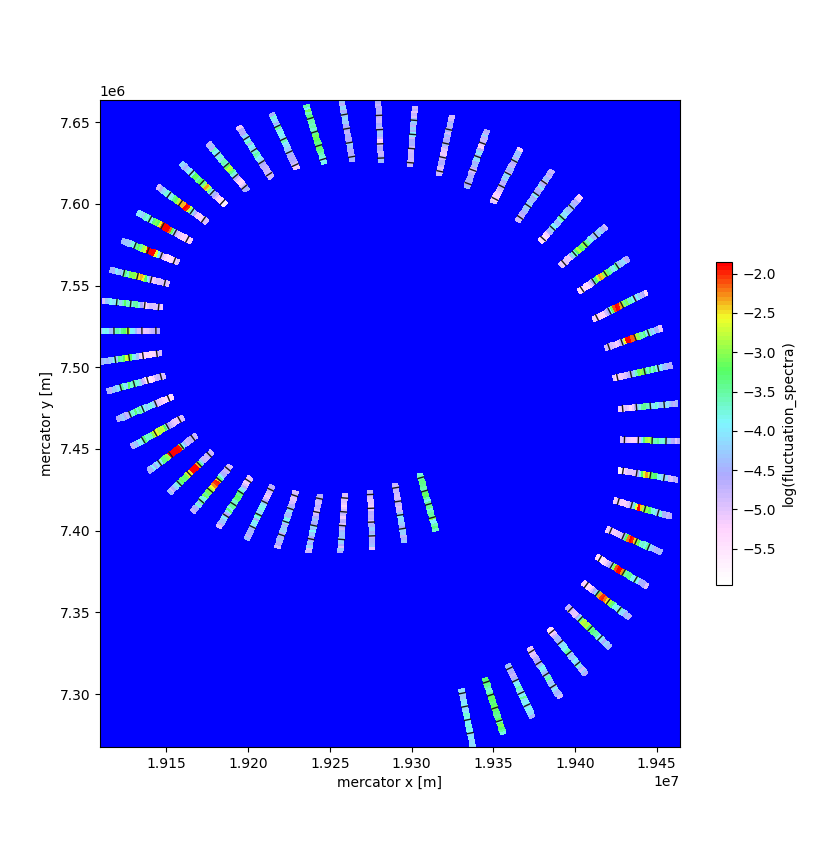

In [4]:
# Choose beam in {2, 4, 6, 8,10}
inc = 10

# Choose ribbon extent around ribbon index of interest. For the nominal macrocycle 0/2/4/6/8/10, 1 rotation is approximately equal to 51 cycles.
nrot = 1 # number of rotations, centered on index
ribbon_slice = slice(index - (26 + (nrot - 1) * 51), index + 26 + (nrot - 1) * 51)

# Call l2s_ribbon_map
kwargs = {'var_name': 'fluctuation_spectra', 'cmap_name': 'cerbere_wind', 'facecolor': 'blue',
          'spec_resample': (26, 2. * np.pi / 1000., 2. * np.pi / 50.), 'vlog': True}
vmins = {2: 0.017007010323660716, 4: 0.012579781668526786, 6: 0.005074055989583334,
         8: 0.00335693359375, 10: 0.002567545572916667}
vmaxs = {2: 0.6303030221121608, 4: 0.5347529820033482, 6: 0.23380649617513546, 8: 0.17073221015929851, 10: 0.1576303792317423}

fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, vmin=vmins[inc], vmax=vmaxs[inc], **kwargs)

# Mimic fluctuation spectra display from CFOSAT portal (overplot)

Here, we display multiple beams at once.

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.core.display.Javascript object>


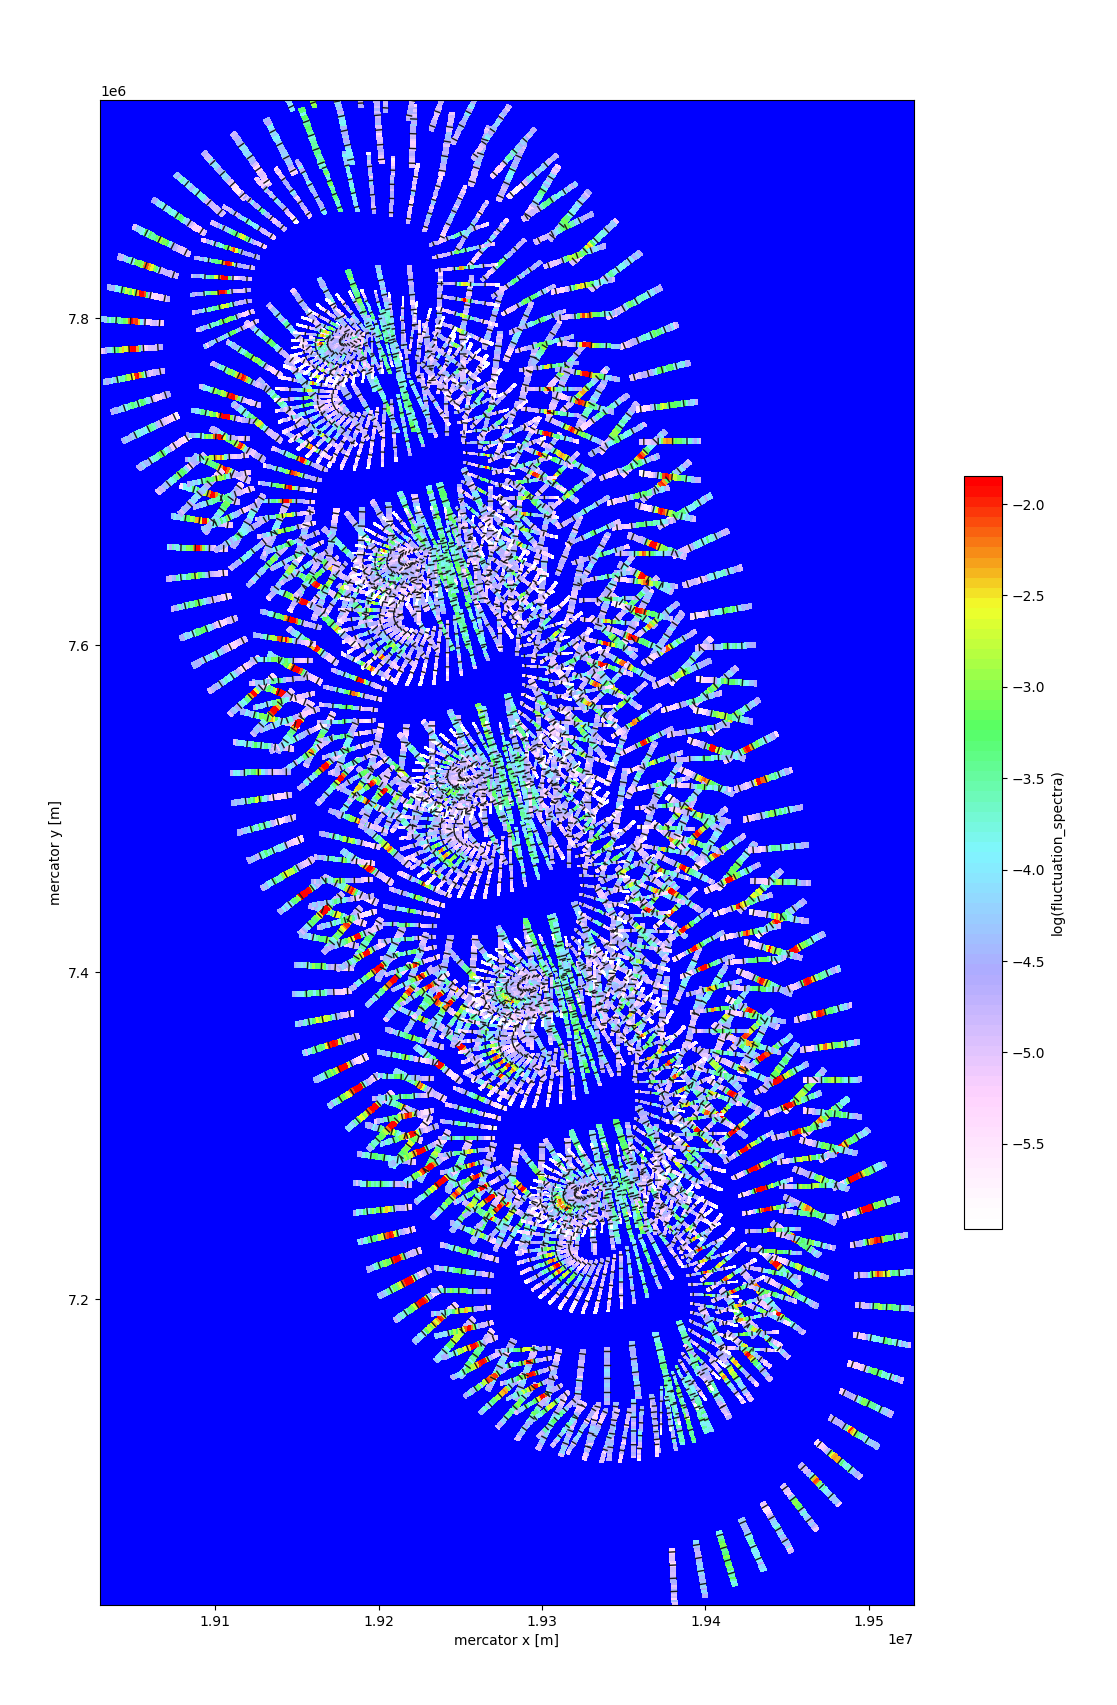

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When mak

In [5]:
# Choose ribbon extent around ribbon index of interest. For the nominal macrocycle 0/2/4/6/8/10, 1 rotation is approximately equal to 51 cycles.
nrot = 3 # number of rotations, centered on index
ribbon_slice = slice(index - (26 + (nrot - 1) * 51), index + 26 + (nrot - 1) * 51)

# First call l2s_ribbon_map at beam 10 (largest area)
kwargs = {'var_name': 'fluctuation_spectra', 'cmap_name': 'cerbere_wind', 'facecolor': 'blue',
          'spec_resample': (26, 2. * np.pi / 1000., 2. * np.pi / 50.), 'vlog': True}
vmins = {2: 0.017007010323660716, 4: 0.012579781668526786, 6: 0.005074055989583334,
         8: 0.00335693359375, 10: 0.002567545572916667}
vmaxs = {2: 0.6303030221121608, 4: 0.5347529820033482, 6: 0.23380649617513546, 8: 0.17073221015929851, 10: 0.1576303792317423}
inc = 10
fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, vmin=vmins[inc], vmax=vmaxs[inc], **kwargs)

# Loop over other beams using the same figure as input
# Note: diplayed area and colorbar remain those of the first call to l2s_ribbon_map()
for inc in [8, 6, 4, 2]:
    fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, vmin=vmins[inc], vmax=vmaxs[inc], **kwargs, figure=fig)

# Discover other L2S variables

Here, we use the l2s_ribbon_map() function in order to display other L2S variables.

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.core.display.Javascript object>


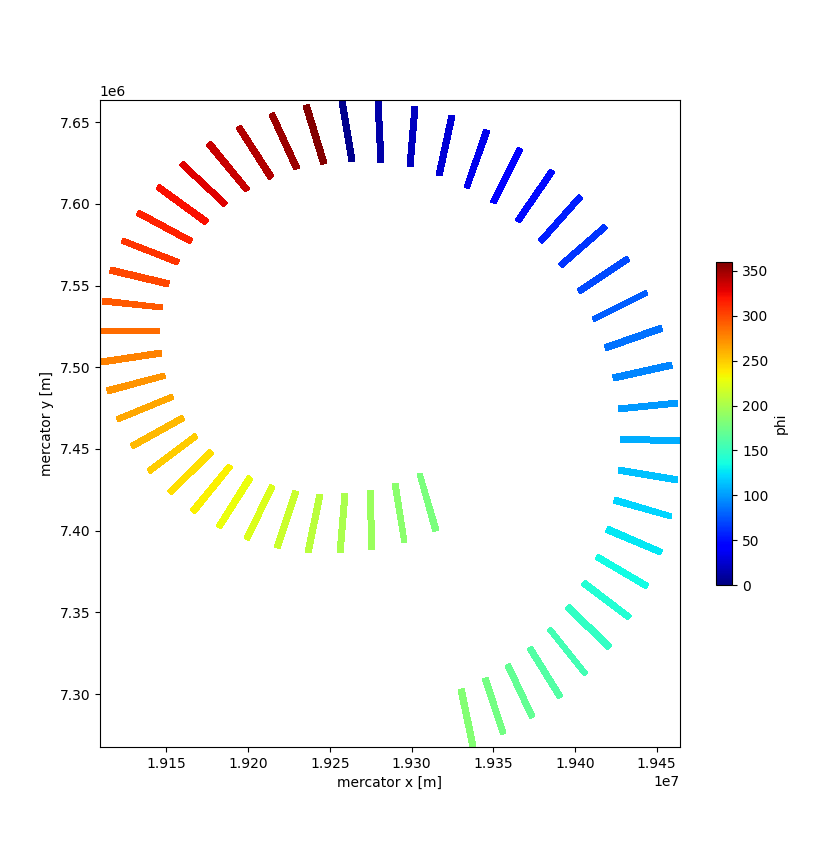

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.core.display.Javascript object>


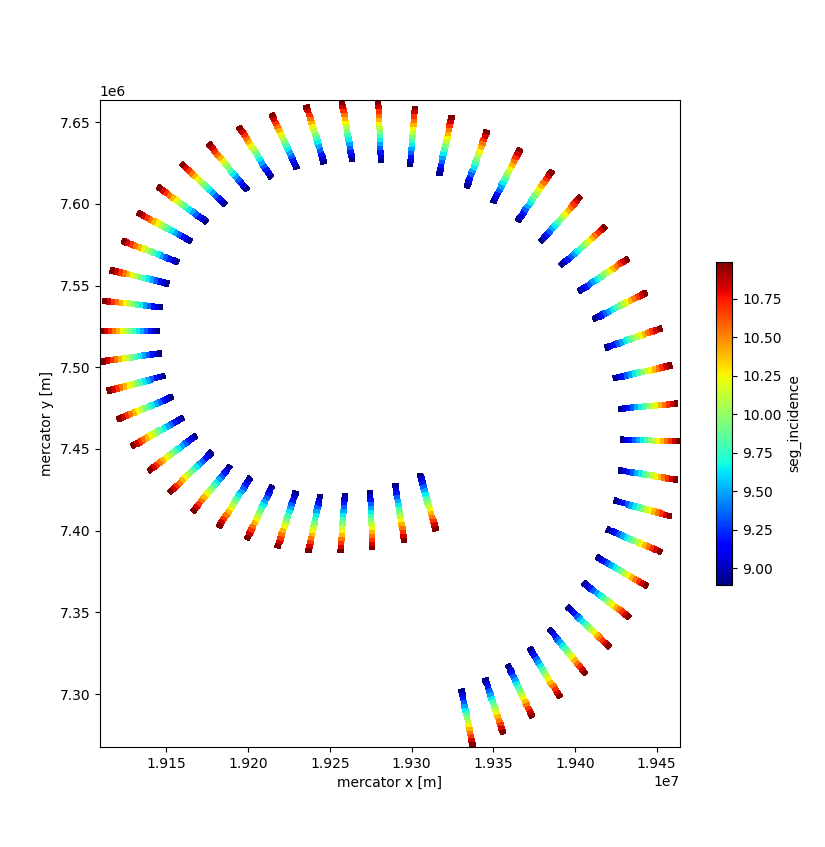

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.core.display.Javascript object>


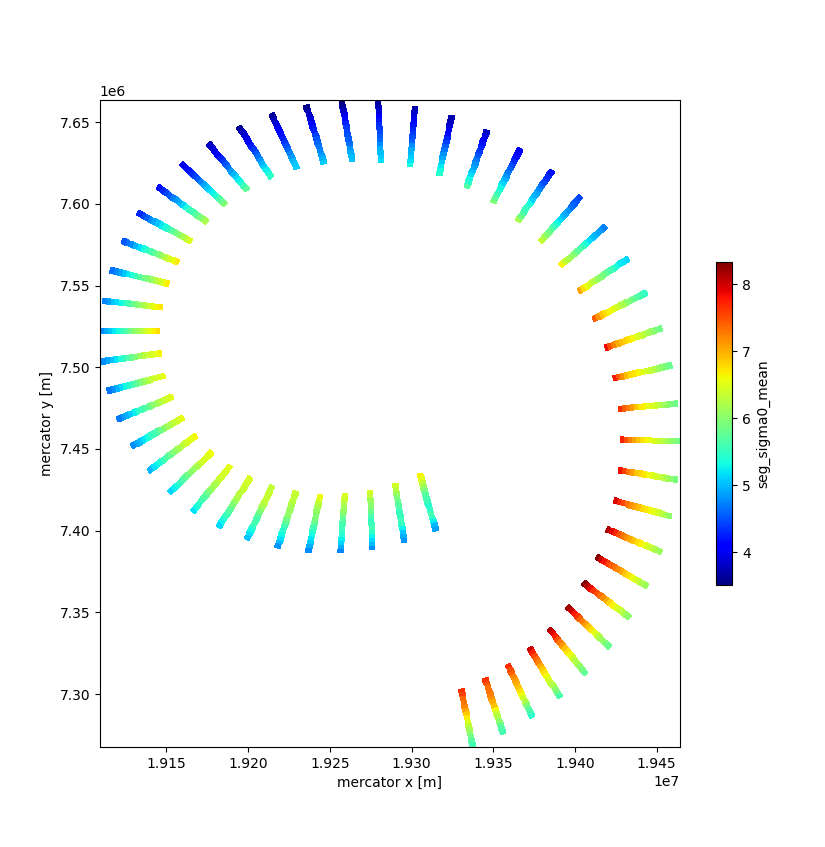

/opt/venv/generic310/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<IPython.core.display.Javascript object>


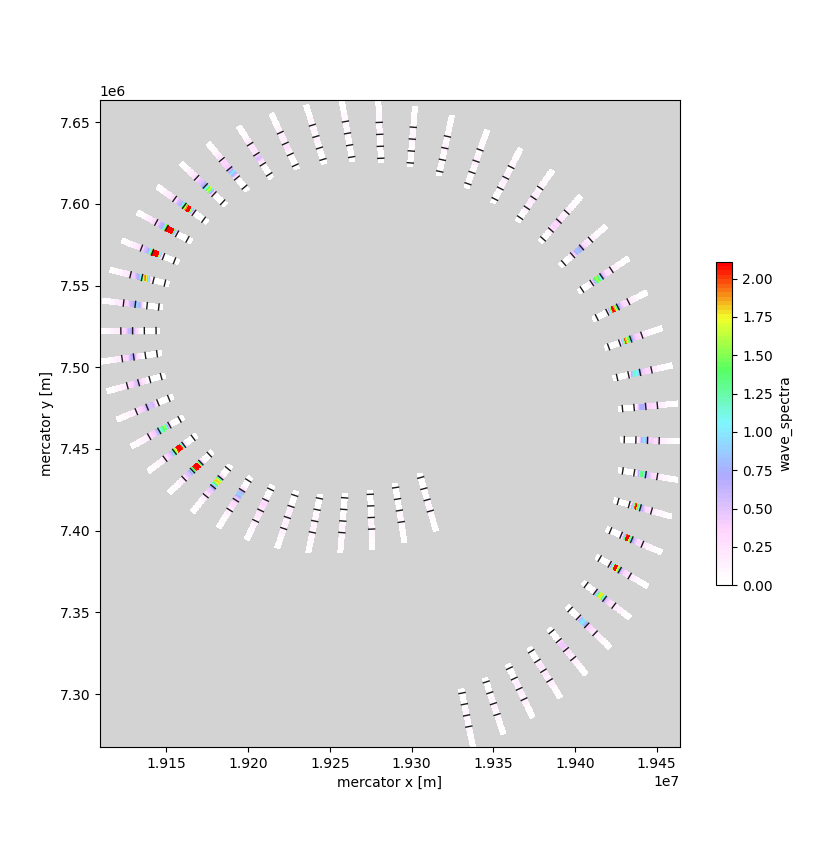

In [6]:
# Choose beam in {2, 4, 6, 8,10}
inc = 10

# Choose ribbon extent around ribbon index of interest. For the nominal macrocycle 0/2/4/6/8/10, 1 rotation is approximately equal to 51 cycles.
nrot = 1 # number of rotations, centered on index
ribbon_slice = slice(index - (26 + (nrot - 1) * 51), index + 26 + (nrot - 1) * 51)

# Azimuth: sensor (phi) or geographic (phi_geo)
fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, var_name='phi', vmin=0, vmax=360)
#fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, var_name='phi_geo', vmin=0, vmax=360)

# Incidence angle over segments used in spectral transform
fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, var_name='seg_incidence')

# Mean sigma0 over segments used in spectral transform
fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, var_name='seg_sigma0_mean')

# Wave (slope) spectra
fig = l2s_ribbon_map(l2s_path_pattern.format(inc), ribbon_slice, var_name='wave_spectra', cmap_name='cerbere_wind', vmin=0., pvmax=99., facecolor='lightgrey')